<a href="https://colab.research.google.com/github/abhinandanarya06/OCR/blob/master/Research_Notebook_on_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OCR Model Training**




###**Installing and Importing Required Libraries**


---



1. OpenCV - Image Processing Library
2. Tensorflow 2.0 - Machine learning Library

In [0]:
!pip install tensorflow==2.0rc1

from IPython.display import clear_output
import cv2 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

clear_output()

###**Getting The DATASET from the repository**


---


This will clone git repository. The hierarchy of this repository as shown below:

          OCR -+-> data -----+--> a
               |             +--> b
               +-> other     :
                   files     :
                             +--> noise
                             

In [0]:
from getpass import getpass
user = getpass('GitHub UserName : ')
password = getpass('GitHub Password : ')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/abhinandanarya06/OCR.git

clear_output()

###**Function to show image**


---


"***imshow(image)***" function show image given as parameter

In [0]:
def imshow(image):
  plt.imshow(image, cmap = 'gray', interpolation = 'bicubic')
  plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
  plt.show()

###**Mapping Letters classes to numbers**
Keywords contains letters with appropriate index number mapping

In [0]:
keywords = [chr(c) for c in range(ord('a'), ord('z')+1)]
cap = ['A', 'B', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'Q', 'R', 'T']
keywords = keywords + cap
keywords = keywords + ['noise']

In [0]:
print(len(keywords))

41


###**Preparing Data for Training**

---



In [0]:
data_images = list()
labels = list()
i = 0
for c in keywords:
    path = 'OCR/data/{}/'.format(c) # IF YOU WANT TO GET DATA FROM OTHER PATH,
    files = os.listdir(path)        # THEN PLEASE MODIFY "path" VARIABLE ACCORDINGLY
    for name in files:
        img = cv2.imread(path+name, 0)
        try:
            img = cv2.resize(img, (30, 30), interpolation = cv2.INTER_AREA)
        except:
            continue
        data_images.append(img)
        labels.append(i)
    i += 1


In [0]:
data_images = np.array(data_images)

IMAGE_DATA_SHAPE = (data_images.shape[0], 30, 30, 1)

data_images = data_images.reshape(IMAGE_DATA_SHAPE)
labels = np.array(labels)

In [0]:
print(labels.shape, data_images.shape)

(48528,) (48528, 30, 30, 1)


###**Model Architecture**


---


Layer Sequence (Sequencial Model) : 


1.   Conv2D Layer
2.   Flatten Operation
3.   Dense Layer with 200 units
4.   10% neuron Dropout Operation
5.   Dense Layer with 41 units




In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (5, 5), activation='relu', input_shape = (30, 30, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(len(keywords))
])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         208       
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               1081800   
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                8241      
Total params: 1,090,249
Trainable params: 1,090,249
Non-trainable params: 0
_________________________________________________________________


**Training starts with callback of early stopping with patience 2**

---



In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
model.fit(data_images, labels, epochs=10, callbacks = [callback])
clear_output()

In [0]:
test_loss, test_acc = model.evaluate(data_images,  labels, verbose=2)

print('\nTest accuracy:', test_acc)

48528/1 - 14s - loss: 0.0428 - accuracy: 0.9758

Test accuracy: 0.9758284




---


---





# **OCR Model Testing**


 

###**Saving the trained model**


---

'model' model is saved in current directory with name 'model.hd5'


In [0]:
model.save('model.h5')
clear_output()

### **Load Model**

---



In [0]:
model = tf.keras.models.load_model('model.h5')

####**Adding Softmax Activation**

---



In [0]:
text_detector = tf.keras.Sequential(
    model,
    tf.keras.layers.Softmax()
)

### **OCR Deployment Demo (Testing Model)**


---



#####**Some Conventions**

In [0]:
X = 0   # X coordinate of the character in image space
Y = 1   # Y coordinate of the character in image space
POS = 1    # shows and return the (x,y) coordinate of image space
SHAPE = 2  # shows and return the (width, height) of character contour in image space
W = 0 # width of the character
H = 1 # height of the character

#####"***check_in(c, region)***" checks if character is present in the given region "*region*" of the image space

In [0]:
def check_in(c, region):
    x, y, w, h = region
    center_x = c[POS][X]+c[SHAPE][W]/2
    center_y = c[POS][Y]
    if (center_x > x-1 and center_x < x+w+1) and (center_y > y-1 and center_y < y+h+1):
        return True
    return False

#####"***get_region(c, regions)***" finds the region in the given list of regions "*regions*" in image space and return it

In [0]:
def get_region(c, regions):
    for region in regions:
        if check_in(c, region):
            return region
    return False

#####"***sort_chars(line)***" Function to sort characters in given line

In [0]:
def sort_chars(line):
    res = list()
    while len(line) > 0:
        mx = 100000
        m = 0
        for c in line:
            if c[POS][X] <= mx:
                mx = c[POS][X]
                m = c
        line.remove(m)
        res.append(m)
    return res

#####"***sort_lines_by_yval(lines)***" function sorts list of lines according to its y coordinate in image space

In [0]:
def sort_lines_by_yval(lines):
    res = list()
    while len(lines) > 0:
        mn = 100000
        m = 0
        for line in lines:
            if line[0][POS][Y] < mn:
              mn = line[0][POS][Y]
              m = line
        lines.remove(m)
        res.append(m)
    return res

#####"***group_chars_by_line(characters)***" Function to group characters in given image by lines

In [0]:
def group_chars_by_line(characters):
  lines = list()
  linei = 0
  while len(characters) > 0:
      m = characters[0]
      my = m[1][1]
      my_plus_h = m[1][1]+m[2][1]
      lines.append([m])
      for c in characters[1:]:
          if my <= c[POS][Y]+c[SHAPE][H]/2 and c[POS][Y]+c[SHAPE][H]/2 <= my_plus_h:
              if my > c[POS][Y]:
                  my = c[POS][Y]
              if my_plus_h < c[POS][Y]+c[SHAPE][H]:
                  my_plus_h = c[POS][Y]+c[SHAPE][H]
              lines[linei].append(c)
              characters.remove(c)
      lines[linei]= sort_chars(lines[linei])
      linei += 1
      characters.remove(m)
  return lines

#####"***apply_ocr(img)***" is the function that does actual ocr operation on image parameter to get text

In [0]:
def apply_ocr(img, text_detector):
    avg_text_height = 0 # will be assigned with Average Height of text character
    character_list = list() # will contain necessary text character to be extracted
    img = cv2.medianBlur(img,5)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,21,10) # will remove maximum noise and make image suitable for contour dt
    contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    black_map = img.copy()
    black_map[:, :] = 0
    i = 0
    for contour in contours:
        try:
            x,y,w,h = cv2.boundingRect(contour)
            try:
                cnt = img[y-2:y+h+2, x-2:x+w+2]
            except:
                cnt = img[y:y+h, x:x+w]
            cnt = cv2.resize(cnt, (30, 30), interpolation = cv2.INTER_AREA)
            cnt = cnt.reshape((1, 30, 30, 1))
            class_pred = np.argmax(text_detector.predict(cnt))
            if class_pred < 40:
                avg_text_height += h
                cv2.rectangle(black_map, (x,y), (x+w+w//4, y+h), 255, -1)
                character_list.append([keywords[class_pred], (x,y), (w,h)])
                i += 1
        except:
              continue
    avg_text_height /= i # Average Height of text character
    text = group_chars_by_line(character_list)
    text = sort_lines_by_yval(text)
    contours, hierarchy = cv2.findContours(black_map, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    regions = list() # will contain regions of words for grouping chars by word
    for contour in contours:
        region = cv2.boundingRect(contour)
        if region[SHAPE + H] <= avg_text_height*7:
          regions.append(region)
    del contours

    TEXT = ''
    for l in text:
        char = l[0]
        region = get_region(char, regions)
        if not region:
            continue
        for char in l:
            if not check_in(char, region):
                TEXT = TEXT + ' '
                r = get_region(char, regions)
                if not r:
                    continue
                region = r
            TEXT = TEXT + char[0]
        TEXT = TEXT + '\n'
    return TEXT

#####**Main Run Start Point**

---



* Before running this start point, Please check if 
 *test_image_path* variable have path to your own test images or not.
* If not, please modify the path variable

****************************** Text on 1.jpg ******************************


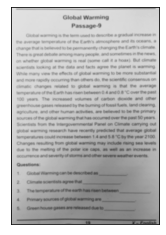

GT ohaT warmx ng
passage g
w
Glbwi h d d b dual l norease l n
oa warmi ng i s te term use to esorl e a gra
tihe average temperature of the Ea h s atmosphere and l ts ooeans a
ohange that l s bel i eved to be permanentiy ohangl ng the Ea h s oh l mate
There ls great debate among many peopi e and sometl mes l n the news
on whether ghobah warml ng i s real some oal l l t a hoax But ol l mate
sol entlsts l ookl ng at the data and faots agree the gl anet l s warml ng
whlle many vl ew the ekeots ot gl obal warml ng to be more substanti al
and more rapl dly ooourrl ng than others do the sol entl l o oonsensus on
ol lmatlo ohanges rek ated to gl obal warml ng ls that the average
temperature ot the Ea h has rlsen between o and o a c oMer the past
oo years The l noreased vol umes of oarbon dl oxl de and other
greenhouse gases released by the burnl ng of fossi l fuel s l and oh earl n w g
agrlouk ture and other human aotlvl ti es are bel i eved to be the pri ma
souroes of the gl obal warmi ng tha

In [0]:
test_images_path = 'OCR/sample_test_image/' # IF YOU PLACE TEST IMAGE INSIDE OCR DIRECTORY,
                                            # THEN PLEASE MODIFY "test_images_path" variable


imgs = [f for f in os.listdir(test_images_path) if f.endswith('.jpg')]
img_no = 0
for img in imgs:
    print('*'*30, 'Text on {}'.format(img), '*'*30)
    img = cv2.imread(test_images_path + img, 0)
    TEXT = apply_ocr(img, text_detector)
    imshow(img)
    print(TEXT)
    print('-'*80, '\n\n')
    img_no += 1